# Stalker, startup due dilligence automation

In [151]:
# Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sql 
from IPython.display import Image, display
from bs4 import BeautifulSoup as bs
import requests
from difflib import get_close_matches
import json
# Twitter sentiment analysis
import tweepy
from textblob import TextBlob
# News API
import newsapi
from newsapi import NewsApiClient
# Web
import webbrowser

In [131]:
newsapi = NewsApiClient(api_key='f4b7461debe141aaa97906aaa15774e0')

In [132]:
news_sources = 'the-verge,buzzfeed,engadget,hacker-news,mashable,reddit-r-all,wired,techcrunch'

In [ ]:
# Twitter API
consumer_key = 'z7JowVKfk7O7e91kqcAXTHvWm'
consumer_key_secret = '8KkTo5G3NhaX2gLIF3MMIl5Kb2U3N21kBrmb7pAEIMXBLRHDjo'
access_token = '266094721-7wiXyVFTvA5Zdsj5sNFiR5w2wokjROsT2bNrkb2w'
access_token_secret = 'huhhS6OCprQpyz6KDm5CQbXvymERJNP6wesztk0cmfn7m'

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [4]:
# Connect to database
from sqlalchemy import create_engine
driver = 'mysql+pymysql:'
user = 'alvaro'
password = 'stalvaro19962013'
ip = '35.246.28.129'
database = 'data_crunch'
connection_string = f'{driver}//{user}:{password}@{ip}/{database}?charset=utf8'
engine = create_engine(connection_string)

In [5]:
# Get data from database
companies = pd.read_sql_table(table_name='companies15', con=connection_string)
investments = pd.read_sql_table(table_name='investments15', con=connection_string)
people = pd.read_sql_table(table_name='people', con=connection_string)
rounds = pd.read_sql_table(table_name='rounds15', con=connection_string)

In [9]:
investments = investments.dropna(subset=['raised_amount_usd', 'company_category_list'])
sector_list0 = []
sector_list = []
for item in investments['company_category_list']:
    if ',' in item:
         sector_list0.append(item.split(sep= ', '))
    else:
        sector_list0.append(item)
for i in sector_list0:
    if type(i) == list:
        for sec in i:
            sector_list.append(sec)
        
    else:
        sector_list.append(i)

In [10]:
companies_list = []
for i in companies.name:
    companies_list.append(i)


## Getting info about the company from the user

In [11]:
def retrieve_name(my_name):
    
    if my_name in companies_list:
        return my_name
    elif len(get_close_matches(my_name, companies_list)) > 0:
        action = input("Did you mean %s instead? [y or n]: " % get_close_matches(my_name, companies_list)[0])
        if (action == "y"):
            return get_close_matches(my_name, companies_list)[0]
        elif (action == "n"):
            return my_name
        else:
            return("we don't understand you. Apologies.")


In [122]:
name0 = input('Name of the company: ')
name = retrieve_name(name0)

Name of the company: Tesla Motors


In [13]:
def retrieve_sector(my_sector):
    
    if my_sector in sector_list:
        return my_sector
    elif len(get_close_matches(my_sector, sector_list)) > 0:
        action = input("Did you mean %s instead? [y or n]: " % get_close_matches(my_sector, sector_list) [0])
        if (action == "y"):
            return get_close_matches(my_sector, sector_list)[0]
        else:
            return my_sector
        else:
            return("we don't understand you. Apologies.")


In [120]:
sector0 = input('In what sector is this company working?: ')
sector = retrieve_sector(sector0)


In what sector is this company working?: Automotive


In [125]:
founder = input('What is the name of the founder?: ')

What is the name of the founder?: Elon Musk


## Looking for info in Crunchbase

In [149]:
def category(sector):
    # Gather tweets
    public_tweets = api.search(sector)
    # Gather news
    public_news = newsapi.get_everything(q=sector,sources=news_sources,language='en')
    # Prepare the data for the sector
    sector_investments = investments[investments['company_category_list'].str.contains(sector)].drop('index',axis=1)
    sector_investments.reset_index(drop=True)
    sector_investments['funded_at'] = pd.to_datetime(sector_investments['funded_at'])
    sector_investments['Year'] = sector_investments['funded_at'].apply(lambda x: x.year )
    sector_investments['Month'] = sector_investments['funded_at'].apply(lambda x: x.month )
    sector_investments['Day'] = sector_investments['funded_at'].apply(lambda x: x.day )
    # Sentiment analysis Twitter
    sentiment_list = []
    for tweet in public_tweets:
        analysis = TextBlob(tweet.text)
        sentiment_list.append(analysis.sentiment[0])
    if sum(sentiment_list)>0:
         sent = 'Positive'
    elif sum(sentiment_list)<0:
        sent = 'Negative'
    else:
        sent = 'Neutral'
    print(f"The sentiment about {sector} industry in Twitter is {sent}")
    # Sentiment analysis news
    news_list = []
    for piece in range(len(public_news['articles'])):
        news_list.append(TextBlob(public_news['articles'][piece]['title']).sentiment[0])
        news_list.append(TextBlob(public_news['articles'][piece]['description']).sentiment[0]) 
    if sum(news_list)>0:
        news_sent = 'Positive'
    elif sum(news_list)<0:
        news_sent = 'Negative'
    else:
        news_sent = 'Neutral'
    print(f"There have been {len(public_news)} news pieces about {sector} industry recently and are in general {news_sent}")
    # create plot
    sector_year = sector_investments.groupby(['Year']).sum()[-10:]
    movement = ((sector_year.raised_amount_usd.iloc[len(sector_year)-1] - sector_year.raised_amount_usd.iloc[0])/sector_year.raised_amount_usd.iloc[0]*100)
    if sector_year.raised_amount_usd.iloc[0] + sector_year.raised_amount_usd.iloc[len(sector_year)-1] >= 0:
        in_dec = 'increased'
        grow = 'growing'
    else:
        in_dec = 'decreased'
        grow = 'falling'
        movement = movement[1:]
    sns.lineplot(x=sector_year.index, y=sector_year.raised_amount_usd).set_title(f'Evolution of the amount invested in {sector}')
    peak_year =  sector_year.index[sector_year['raised_amount_usd']== max(sector_year.raised_amount_usd)].to_list()
    peak_amount = max(sector_year.raised_amount_usd)
    low_amount = min(sector_year.raised_amount_usd)
    low_year = sector_year.index[sector_year['raised_amount_usd']== min(sector_year.raised_amount_usd)].to_list()
    format_doll = ',.2f'
    print(f"""The amount of money invested in {sector} companies has {in_dec} by {format(abs(movement),format_doll)}% in the last {len(sector_year)} years, 
it is expected to keep {grow} by X the next  X years. 
It peaked in year {peak_year} with ${format(peak_amount,format_doll )} invested and its lowest point was in year {low_year} with ${format(low_amount,format_doll)} invested.""")
    plt.ylabel('Raised amount in USD')
    plt.show()
    investments_per_year = sector_investments.groupby(['Year']).count()
    sns.lineplot(x=investments_per_year.index[-10:], y=investments_per_year.Day[-10:]).set_title(f'Evolution of the number of investment in {sector}')
    plt.ylabel('Number of investments')
    print("""Plot explanaition average investment
    
    """)
    plt.show()

The sentiment about Automotive industry in Twitter is Positive
There has been 3 news pieces about Automotive industry recently and are in general Positive
The amount of money invested in Automotive companies has increased by 2,819.66% in the last 10 years, 
it is expected to keep growing by X the next  X years. 
It peaked in year [2015] with $20,351,789,721.62 invested and its lowest point was in year [2007] with $674,545,389.00 invested.


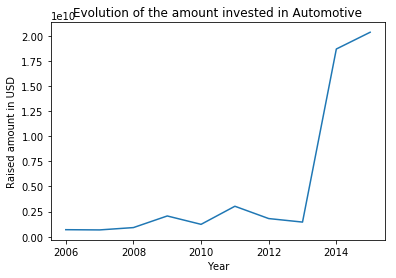

Plot explanaition average investment
    
    


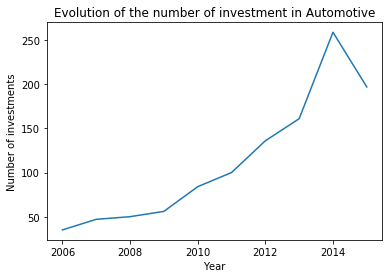

In [150]:
category(sector)

In [78]:
def founders(founder):
    full_name = founder.split()
    public_tweets = api.search(founder)
    for i in range(len(people)):
        if people.first_name.iloc[i] == full_name[0] and people.last_name.iloc[i]==full_name[1]:
            display(Image(url=people.profile_image_url[i]))
            print(f'We found this information about {founder}:')
            print(f"Founder's name: {people.first_name[i]} {people.last_name[i]} ")
            print(f"Title: {people.title[i]}")
            print(f"Organization: {people.organization[i]}")
            if people.organization[i] != name:
                print('This person might not be working full time')
            print(f"Location: {people.location_city[i]}, {people.location_region[i]}, {people.location_country_code[i]}")
            if people.twitter_url[i] != None:
                print(f"Twitter URL: {people.twitter_url[i]}")
            if people.linkedin_url[i] != None:
                print(f"Linkedin URL: {people.linkedin_url[i]}")
            if people.facebook_url[i] != None:
                print(f"Facebook URL: {people.facebook_url[i]}")
    # Sentiment analysis
    sentiment_list = []
    for tweet in public_tweets:
        analysis = TextBlob(tweet.text)
        sentiment_list.append(analysis.sentiment[0])
    if sum(sentiment_list)>0:
         sent = 'Positive'
    elif sum(sentiment_list)<0:
        sent = 'Negative'
    else:
        sent = 'Neutral'
    print(f"The sentiment about {founder} in Twitter is {sent}")
            
        

In [126]:
founders(founder)

We found this information about Elon Musk:
Founder's name: Elon Musk 
Title: Product Architect & CEO at Tesla
Organization: Tesla
This person might not be working full time
Location: Los Angeles, California, US
Twitter URL: http://twitter.com/elonmusk
Linkedin URL: https://www.linkedin.com/company/elon-musk-news/
Facebook URL: https://www.facebook.com/ermusk
The sentiment about Elon Musk in Twitter is Positive


In [ ]:
for i in range(len(companies)):
    if name in companies.name[i]:
        print(companies.iloc[i])

In [20]:
def startup(name):
    company = companies[companies['name'] == name]
    #display(Image(url=company.profile_image_url))
    print(f"Company name: {company.name.item()}")
    print(f"Total money raised: ${round(company.funding_total_usd.item(),2)}")
    print(f"Total rounds: {company.funding_rounds.item()}")
    print(f"Status: {company.funding_rounds.item()}")
    # print(f"Location: {people.location_city[i]}, {people.location_region[i]}, {people.location_country_code[i]}")
    # return Image(url=people.profile_image_url[i])

In [123]:
startup(name)

Company name: Tesla Motors
Total money raised: $823000000.0
Total rounds: 11


In [162]:
companies

,index,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,0,/organization/-fame,#fame,http://livfame.com,Media,1.000000e+07,operating,IND,16,Mumbai,Mumbai,1,None,2015-01-05,2015-01-05
1,1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,7.000000e+05,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3.406878e+06,operating,None,None,None,None,1,None,2014-01-30,2014-01-30
3,3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2.000000e+06,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,0.000000e+00,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24
5,5,/organization/01games-technology,01Games Technology,http://www.01games.hk/,Games,4.125000e+04,operating,HKG,None,Hong Kong,Hong Kong,1,None,2014-07-01,2014-07-01
6,6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,7.628510e+05,operating,CAN,BC,Vancouver,Vancouver,2,1997-01-01,2009-09-11,2009-12-21
7,7,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,3.360000e+07,operating,USA,CA,SF Bay Area,Mountain View,4,2011-01-01,2013-01-03,2015-11-09
8,8,/organization/1,One Inc.,http://whatis1.com,Mobile,1.150050e+06,operating,USA,CA,SF Bay Area,San Francisco,3,2011-08-01,2011-07-20,2014-02-05
9,9,/organization/1-2-3-listo,"1,2,3 Listo",http://www.123listo.com,E-Commerce,4.000000e+04,operating,CHL,12,Santiago,Las Condes,1,2012-01-01,2013-02-18,2013-02-18


## Google search

In [163]:
from googlesearch import search

In [170]:
query = "elizabeth holmes"
  
for s in search(query, tld="com", num=10, stop=10, pause=3, lang='en'): 
    print(s) 

https://en.wikipedia.org/wiki/Elizabeth_Holmes
https://en.wikipedia.org/wiki/Ramesh_Balwani
https://en.wikipedia.org/wiki/Theranos
https://en.wikipedia.org/wiki/George_Shultz
https://en.wikipedia.org/wiki/Bad_Blood:_Secrets_and_Lies_in_a_Silicon_Valley_Startup
https://es.wikipedia.org/wiki/Elizabeth_Holmes
https://www.businessinsider.com/theranos-founder-ceo-elizabeth-holmes-life-story-bio-2018-4
https://www.youtube.com/watch?v=PvznWSEKoEE
https://www.cnbc.com/2018/05/22/stories-from-bad-blood-book-on-theranos-and-elizabeth-holmes.html
https://www.forbes.com/profile/elizabeth-holmes/


### To improve
> Message if cannot find info

> Suggestions (Difflib)

> Twitter feed with stats

> News API number of articles and sentiment
